In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('data.csv')
df.shape

(23524, 13)

In [3]:
df.groupby('gender_of_respondent').count()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,relationship_with_head,marital_status,education_level,job_type
gender_of_respondent,,,,,,,,,,,,
Female,13877,13877,13877,13877,13877,13877,13877,13877,13877,13877,13877,13877
Male,9647,9647,9647,9647,9647,9647,9647,9647,9647,9647,9647,9647


In [4]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [5]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)

<ipython-input-5-02e3f9e08314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
<ipython-input-5-02e3f9e08314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
<ipython-input-5-02e3f9e08314>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [6]:
country_avg = dict(x_tr.groupby('country')['household_size'].mean())

In [7]:
country_avg

{'Kenya': 3.980457472795914,
 'Rwanda': 4.490705177446612,
 'Tanzania': 2.338022587675847,
 'Uganda': 4.945707070707071}

In [8]:
x_tr.loc[x_tr['country'] == 'Kenya', ['mean_hh']] = x_tr['household_size'] / 3.98
x_tr.loc[x_tr['country'] == 'Rwanda', ['mean_hh']] = x_tr['household_size'] / 4.49
x_tr.loc[x_tr['country'] == 'Tanzania', ['mean_hh']] = x_tr['household_size'] / 2.34
x_tr.loc[x_tr['country'] == 'Uganda', ['mean_hh']] = x_tr['household_size'] / 4.95

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [9]:
x_tr_cont = x_tr[['year','household_size','age_of_respondent','is_urban','cellphone','is_male','mean_hh']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [10]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-10-4a08e3cd5a34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-10-4a08e3cd5a34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
y_tr['no_acc'] = np.where(y_tr['bank_account'] == 'No', 1,0)
y_tr.drop(columns='bank_account',inplace=True)

<ipython-input-11-dc6323112d16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['no_acc'] = np.where(y_tr['bank_account'] == 'No', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
#from sklearn.preprocessing import minmax_scale

#x_tr_cont[['household_size','age_of_respondent']] = minmax_scale(x_tr_cont[['household_size','age_of_respondent']])

In [13]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_tr_cat)

ohe_x_train = ohe.transform(x_tr_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_tr_df = pd.DataFrame(ohe_x_train, columns=columns, index=x_tr.index)

In [14]:
combo_train_df = pd.concat([x_tr_cont, ohe_x_tr_df], axis=1)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(combo_train_df, y_tr, test_size=.20, random_state=11)

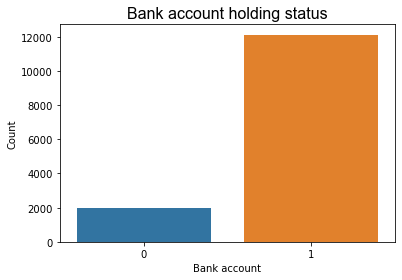

In [16]:
sns.countplot(x='no_acc', data=y_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Bank account')
plt.ylabel('Count')
plt.show;

In [17]:
count_no_acc = len(y_train[y_train['no_acc']==1])
count_acc = len(y_train[y_train['no_acc']==0])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", pct_of_no_acc*100)
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", pct_of_acc*100)

percentage of no account: 85.9288649567805
percentage of account 14.071135043219499


Classes are __very imbalanced__ - investigate threshold, over and undersampling

In [18]:
df_train = pd.concat([x_train,y_train],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

In [19]:
# Create dateframes to use for visualisations
df_vis_cont = pd.concat([x_tr_cont,y_tr],axis=1)
df_vis_cat = pd.concat([ohe_x_tr_df,y_tr],axis=1)

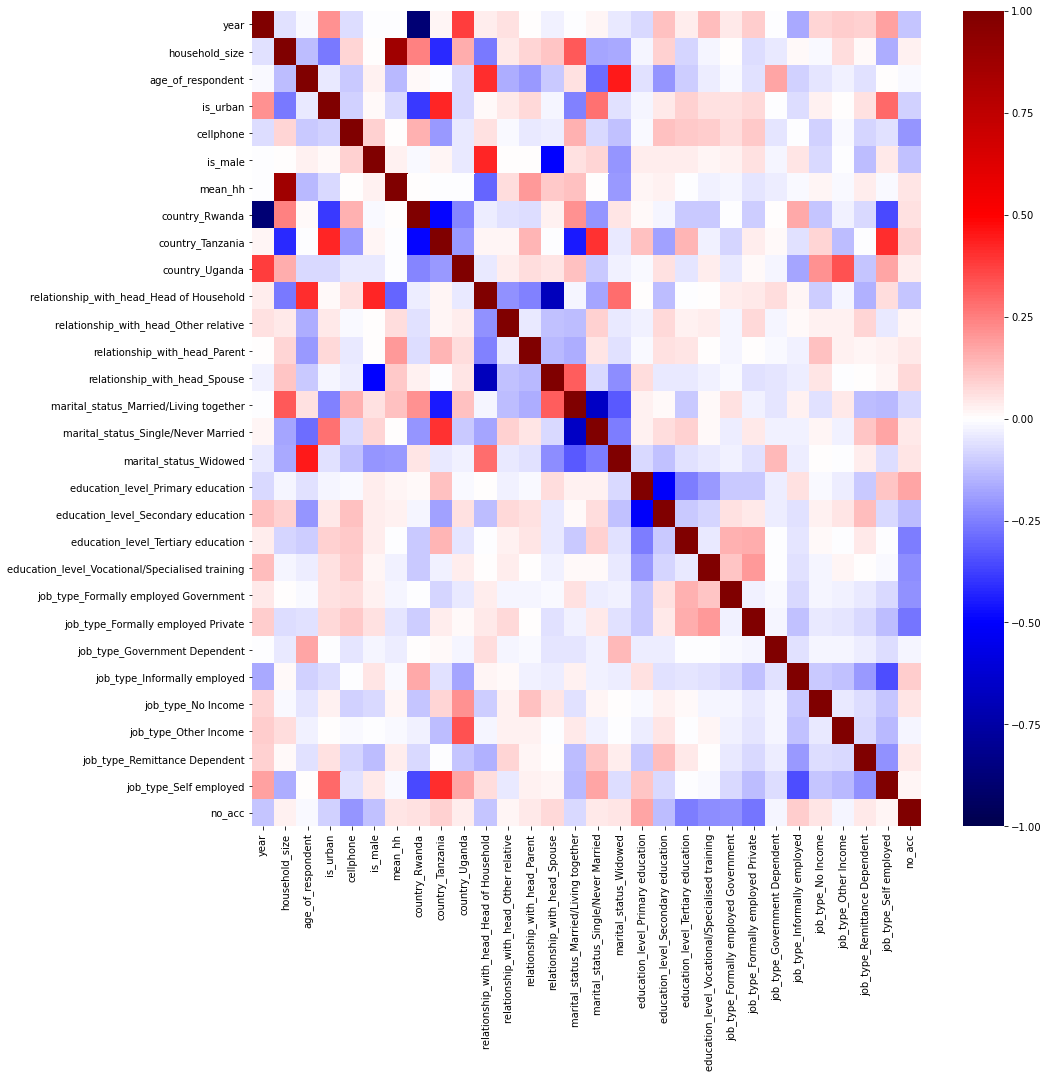

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

## Simple logistic regression

Testing with a single variable: is_male

In [21]:
#Model on is_male first
lm_1 = sm.Logit(df_train['no_acc'],  # with statsmodels, `y` comes first
                sm.add_constant(df_train[['is_male']]))  # and then `x`
lm_1 = lm_1.fit()

Optimization terminated successfully.
         Current function value: 0.399382
         Iterations 6


In [22]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 no_acc   No. Observations:                14114
Model:                          Logit   Df Residuals:                    14112
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Feb 2021   Pseudo R-squ.:                 0.01691
Time:                        10:27:39   Log-Likelihood:                -5636.9
converged:                       True   LL-Null:                       -5733.9
Covariance Type:            nonrobust   LLR p-value:                 4.398e-44
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1251      0.035     60.055      0.000       2.056       2.194
is_male       -0.6779      0.049    -13.887      0.000      -0.774      -0.582
==============================================================================
"""

In [23]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(df_train[['is_male']], df_train['no_acc'])

LogisticRegression(C=100000, solver='newton-cg')

In [24]:
print('intercept: ', round(lm_1.intercept_[0], 4))
print('is_male coef: ', round(lm_1.coef_[0][0], 4))

intercept:  2.1251
is_male coef:  -0.6779


In [25]:
df_eval = df_val.copy()
df_eval['pred'] = lm_1.predict(df_val[['is_male']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['no_acc']

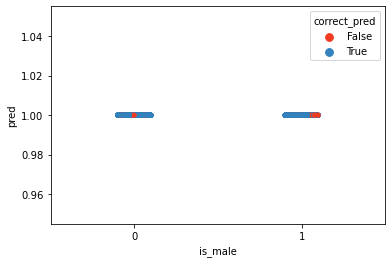

In [26]:
sns.stripplot(data=df_eval,
              x='is_male',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [27]:
lm_1.predict_proba(df_val[['is_male']])[:5]

array([[0.10668258, 0.89331742],
       [0.19044297, 0.80955703],
       [0.10668258, 0.89331742],
       [0.10668258, 0.89331742],
       [0.19044297, 0.80955703]])

In [28]:
confusion_matrix(df_eval['no_acc'], df_eval['pred'])

array([[   0,  492],
       [   0, 3037]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 3037 | 0|
| **is account (1)** | 492 | 0 |

I believe it is predicting all no account because of the following:
* Classes are very imbalanced (85:15 no account to account)
* One variable alone may not be sufficient enough in this instance
* Perhaps because is_male class is also imbalanced?

## Multiple regression - excluding mean hh
The below analysis is a multiple logistic regression for all features 

In [29]:
features = ['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

The below analysis includes all features. Thereafter the analyses remove insignificant features one by one.

In [30]:
lm_2 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_2.fit(df_train[features], df_train['no_acc'])

preds = lm_2.predict(df_val[features])
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_2.score(df_val[features], y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [31]:
print('Feature coefficient results: \n')
for feature, coef in zip(df_train[features].columns, lm_2.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

household_size : -0.001
age_of_respondent : -0.013
is_urban : -0.271
cellphone : -1.626
is_male : -0.455
country_Rwanda : 0.337
country_Tanzania : 1.267
country_Uganda : 1.214
relationship_with_head_Head of Household : -0.795
relationship_with_head_Other relative : -0.118
relationship_with_head_Parent : -0.022
relationship_with_head_Spouse : -0.568
marital_status_Married/Living together : -0.033
marital_status_Single/Never Married : 0.130
marital_status_Widowed : -0.060
education_level_Primary education : -0.758
education_level_Secondary education : -1.759
education_level_Tertiary education : -3.230
education_level_Vocational/Specialised training : -2.770
job_type_Formally employed Government : -1.613
job_type_Formally employed Private : -1.723
job_type_Government Dependent : -1.213
job_type_Informally employed : 0.363
job_type_No Income : 0.190
job_type_Other Income : -0.672
job_type_Remittance Dependent : 0.206
job_type_Self employed : -0.460


In [32]:
lm_2.intercept_

array([5.63949814])

In [33]:
df_val['preds'] = lm_2.predict(df_val[features])

In [34]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [35]:
y_prob = lm_2.predict_proba(df_val[features])

In [36]:
confusion_matrix(df_val['no_acc'], 
                 preds)

array([[ 167,  325],
       [  79, 2958]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 2954 | 83|
| **is account (1)** | 337 | 155 |

Need to understand and decide on the __trade off between recall and precision__

Precision is the number of observations predicted positive over the total actual positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the number of actually positive observations over the number predicted positive. The recall is intuitively the ability of the classifier to find all the positive samples.

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.68      0.34      0.45       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.69      3529
weighted avg       0.87      0.89      0.87      3529



In [38]:
df_val['proba_bank'] = lm_2.predict_proba(df_val[features])[:, 1]

fpr2, tpr2, thresholds2 = roc_curve(df_val['no_acc'],
                                 df_val['proba_bank'])

In [39]:
def plot_roc(true, probas,fpr,tpr):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

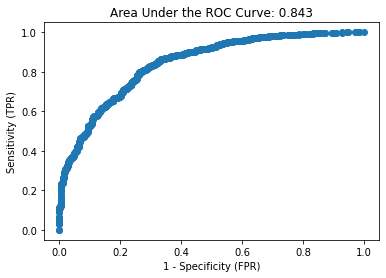

In [40]:
plot_roc(df_val['no_acc'], df_val['proba_bank'],fpr2,tpr2)

## Adjusting threshold

In [41]:
threshold = .50
y_pred = np.where((y_prob[:, 0] > threshold),0,1)

In [42]:
confusion_matrix(df_val['no_acc'], 
                 y_pred)

array([[ 167,  325],
       [  79, 2958]])

In [43]:
df_val['preds'] = np.where((y_prob[:, 0] > threshold),0,1)
df_comp = df_val[(df_val['no_acc'] != df_val['preds']) & (df_val['household_size'] ==1)]

In [44]:
pd.set_option('display.max_columns', None)

## Multiple regression removing insignificant features one by one

Based on logit summary above

## Removing parent and other relative

Based on logit summary above

In [45]:
x_train_9 = df_train.drop(columns = ['year','relationship_with_head_Parent','relationship_with_head_Other relative'])

df_val_9 = df_val.drop(columns = ['year','relationship_with_head_Parent','relationship_with_head_Other relative'])

features9 = ['age_of_respondent','household_size', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [46]:
lm_9 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_9.fit(x_train_9[features9], x_train_9['no_acc'])

preds9 = lm_9.predict(df_val_9[features9])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_9.score(df_val_9[features9], df_val_9['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.886


In [47]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_9[features9].columns, lm_9.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
household_size : -0.001
is_urban : -0.273
cellphone : -1.628
is_male : -0.456
country_Rwanda : 0.338
country_Tanzania : 1.265
country_Uganda : 1.209
relationship_with_head_Head of Household : -0.759
relationship_with_head_Spouse : -0.534
marital_status_Married/Living together : -0.034
marital_status_Single/Never Married : 0.134
marital_status_Widowed : -0.060
education_level_Primary education : -0.760
education_level_Secondary education : -1.760
education_level_Tertiary education : -3.231
education_level_Vocational/Specialised training : -2.771
job_type_Formally employed Government : -1.614
job_type_Formally employed Private : -1.730
job_type_Government Dependent : -1.212
job_type_Informally employed : 0.361
job_type_No Income : 0.189
job_type_Remittance Dependent : 0.205
job_type_Other Income : -0.672
job_type_Self employed : -0.461


In [48]:
confusion_matrix(df_val_9['no_acc'], 
                 preds9)

array([[ 169,  323],
       [  78, 2959]])

No change in recall for non-account but minor improvement in recall for account

In [49]:
print(classification_report(df_val_9['no_acc'], preds9))

              precision    recall  f1-score   support

           0       0.68      0.34      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



## Removing married / living together

In [50]:
x_train_10 = x_train_9.drop(columns='marital_status_Married/Living together')

df_val_10 = df_val_9.drop(columns='marital_status_Married/Living together')

features10 = ['age_of_respondent','household_size', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [51]:
lm_10 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_10.fit(x_train_10[features10], x_train_10['no_acc'])

preds10 = lm_10.predict(df_val_10[features10])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_10.score(
    df_val_10[features10], df_val_10['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.887


In [52]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_10[features10].columns, lm_10.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
household_size : -0.003
is_urban : -0.274
cellphone : -1.643
is_male : -0.461
country_Rwanda : 0.336
country_Tanzania : 1.272
country_Uganda : 1.208
relationship_with_head_Head of Household : -0.772
relationship_with_head_Spouse : -0.555
marital_status_Single/Never Married : 0.152
marital_status_Widowed : -0.038
education_level_Primary education : -0.769
education_level_Secondary education : -1.771
education_level_Tertiary education : -3.240
education_level_Vocational/Specialised training : -2.782
job_type_Formally employed Government : -1.616
job_type_Formally employed Private : -1.733
job_type_Government Dependent : -1.214
job_type_Informally employed : 0.358
job_type_No Income : 0.186
job_type_Remittance Dependent : 0.199
job_type_Other Income : -0.674
job_type_Self employed : -0.464


In [53]:
confusion_matrix(df_val_10['no_acc'], 
                 preds10)

array([[ 170,  322],
       [  78, 2959]])

In [54]:
print(classification_report(df_val_10['no_acc'], preds10))

              precision    recall  f1-score   support

           0       0.69      0.35      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [55]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

In [56]:
df_val_10['proba_bank'] = lm_10.predict_proba(df_val_10[features10])[:, 1]

fpr10, tpr10, thresholds10 = roc_curve(df_val_10['no_acc'],
                                 df_val_10['proba_bank'])

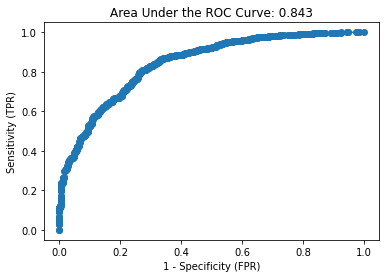

In [57]:
plot_roc(df_val_10['no_acc'], df_val_10['proba_bank'],fpr10,tpr10)

In [58]:
# calculate F1 score
f1_10 = f1_score(df_val_10['no_acc'], preds10)
print('F1 score for model 10:')
f1_10

F1 score for model 10:


0.9366888255777145

## Removing household size

In [59]:
x_train_13 = x_train_10.drop(columns=['household_size','mean_hh'])

df_val_13 = df_val_10.drop(columns=['household_size','mean_hh'])

features13 = ['age_of_respondent','is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [60]:
lm_13 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_13.fit(x_train_13[features13], x_train_13['no_acc'])

preds13 = lm_13.predict(df_val_13[features13])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_13.score(
    df_val_13[features13], df_val_13['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.886


In [61]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_13.columns, lm_13.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
is_urban : -0.273
cellphone : -1.636
is_male : -0.463
country_Rwanda : 0.336
country_Tanzania : 1.275
country_Uganda : 1.207
relationship_with_head_Head of Household : -0.766
relationship_with_head_Spouse : -0.551
marital_status_Single/Never Married : 0.156
marital_status_Widowed : -0.035
education_level_Primary education : -0.764
education_level_Secondary education : -1.765
education_level_Tertiary education : -3.234
education_level_Vocational/Specialised training : -2.776
job_type_Formally employed Government : -1.614
job_type_Formally employed Private : -1.730
job_type_Government Dependent : -1.212
job_type_Informally employed : 0.360
job_type_No Income : 0.189
job_type_Other Income : 0.202
job_type_Remittance Dependent : -0.672
job_type_Self employed : -0.462


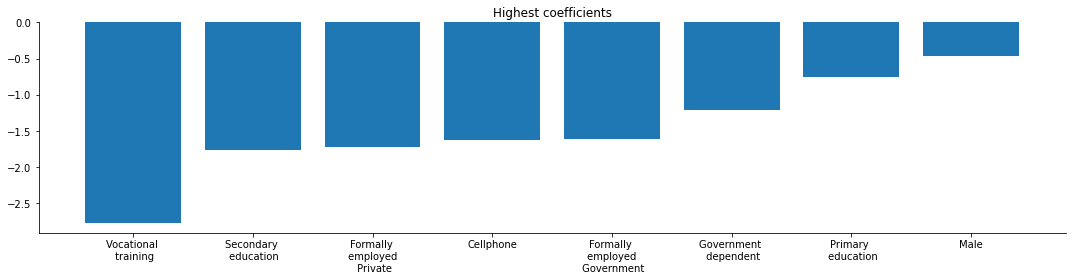

In [62]:
plt.figure(figsize=[15,4])

ticks_x = ['Vocational \n training','Secondary \n education', 
           'Formally \n employed \n Private','Cellphone','Formally \n employed \n Government','Government \n dependent', 
           'Primary \n education','Male']

y = [-2.77, -1.76,-1.73, -1.63,-1.61, -1.21, -0.76,-0.461]

spacing = np.linspace(0,7,8)
plt.bar(ticks_x,y)
plt.xticks(spacing, ticks_x)
plt.title('Highest coefficients')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show;
#plt.savefig("strongestcoefficients.svg")

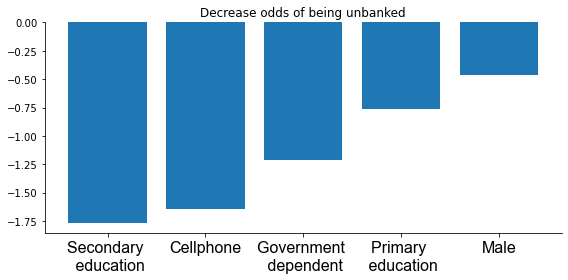

In [136]:
plt.figure(figsize=[8,4])

ticks_x = ['Secondary \n education','Cellphone','Government \n dependent', 'Primary \n education','Male']

y = [-1.77, -1.64, -1.21, -0.76,-0.46]

spacing = np.linspace(0,4,5)
plt.bar(ticks_x,y)
plt.xticks(spacing, ticks_x,family='arial',fontsize=16)
plt.title('Decrease odds of being unbanked')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show;
plt.savefig("decrease.svg")

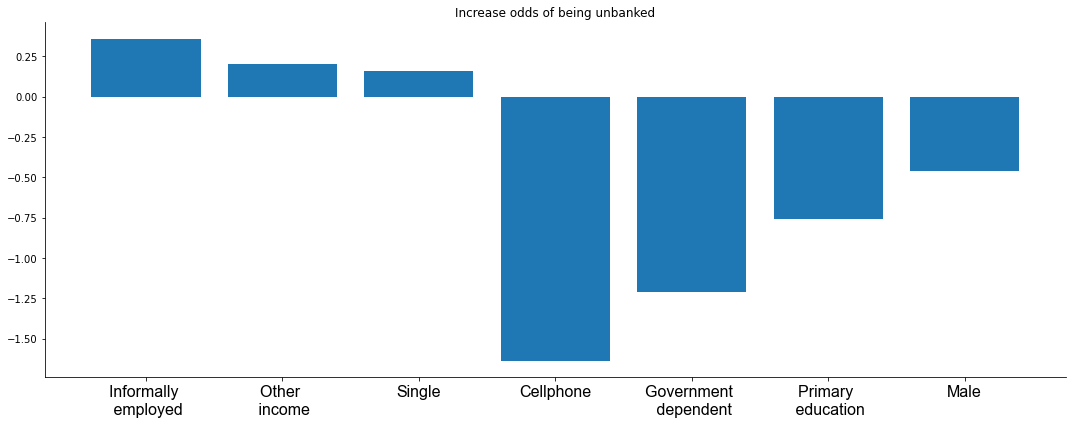

In [143]:
plt.figure(figsize=[15,6])

ticks_x = ['Informally \n employed','Other \n income','Single','Cellphone',
           'Government \n dependent', 'Primary \n education','Male']

y = [0.36, 0.20, 0.16, -1.64, -1.21, -0.76,-0.46]

spacing = np.linspace(0,6,7)
plt.bar(ticks_x,y)
plt.xticks(spacing, ticks_x,family='arial',fontsize=16)
plt.title('Increase odds of being unbanked')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show;
plt.savefig("combinedodds.svg")

In [127]:
confusion_matrix(df_val_13['no_acc'], 
                 preds13)

array([[ 169,  323],
       [  78, 2959]])

In [128]:
lm_13.intercept_

array([5.60881234])

In [129]:
print(classification_report(df_val_13['no_acc'], preds13))

              precision    recall  f1-score   support

           0       0.68      0.34      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [66]:
df_val_13['proba_bank'] = lm_13.predict_proba(df_val_13[features13])[:, 1]

fpr13, tpr13, thresholds13 = roc_curve(df_val_13['no_acc'],
                                 df_val_13['proba_bank'])

In [67]:
df_val_13['preds'] = lm_13.predict(df_val_13[features13])
df_check = df_val_13[(df_val_13['no_acc'] != df_val_13['preds']) & (df_val_13['proba_bank'] >= 0.65)]

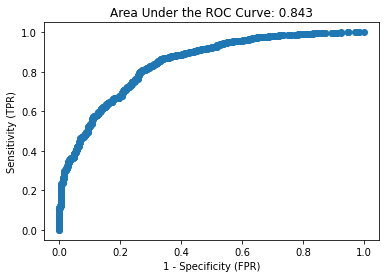

In [68]:
plot_roc(df_val_13['no_acc'], df_val_13['proba_bank'],fpr13,tpr13)
#plt.savefig("roc13.svg")

In [69]:
# calculate F1 score
f1_13 = f1_score(df_val_13['no_acc'], preds13)
print('F1 score for non bank account holiders in model 13:')
f1_13

F1 score for non bank account holiders in model 13:


0.9365405918658015

In [70]:
precision13, recall13, thresholds_13 = precision_recall_curve(df_val_13['no_acc'], df_val_13['proba_bank'])

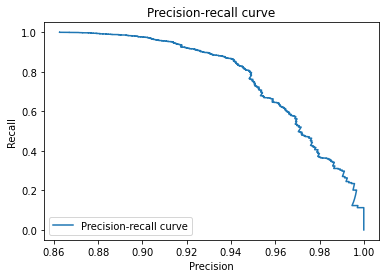

In [71]:
plt.plot(precision13, recall13, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')
_ = plt.legend(loc="lower left")

In [72]:
auc13 = auc(recall13,precision13)
auc13

0.9676787324403971

NOTE THIS DOES NOT LOOK CONSISTENT WITH THE FIGURE ABOVE 

In [73]:
rw_wrong = len(df_check[df_check['country_Rwanda']==1]) / len(df_check)
tz_wrong = len(df_check[df_check['country_Tanzania']==1]) / len(df_check)
ug_wrong = len(df_check[df_check['country_Uganda']==1]) / len(df_check)
ke_wrong = 1 - rw_wrong - tz_wrong - ug_wrong
print("Rwanda wrong:{:0.3f} \nTanzania wrong: {:0.3f} \nUganda wrong:{:0.3f} \nKenya wrong:{:0.3f}".format(rw_wrong,tz_wrong,ug_wrong,ke_wrong))

Rwanda wrong:0.372 
Tanzania wrong: 0.242 
Uganda wrong:0.048 
Kenya wrong:0.338


The majority of the highly confident, incorrect predictions are in Rwanda (37%) and Kenya (33%)

## Adjusting threshold

In [74]:
threshold = .52
y_pred13 = np.where((lm_13.predict_proba(df_val_13[features13])[:, 1] > threshold),1,0)

In [75]:
confusion_matrix(df_val_13['no_acc'], 
                 y_pred13)

array([[ 176,  316],
       [  86, 2951]])

In [76]:
df_val_13['preds'] = np.where((lm_13.predict_proba(df_val_13[features13])[:, 1] > threshold),1,0)
df_comp13 = df_val_13[(df_val_13['no_acc'] != df_val_13['preds'])]

## Oversampling with model 13 features

In [186]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(x_train_13[features13], x_train_13['no_acc'])

In [187]:
from collections import Counter
Counter(y_resampled)

Counter({1: 12128, 0: 12128})

In [188]:
lm_15 = LogisticRegression(C=1,penalty='l1',solver='liblinear')
lm_15.fit(X_resampled[features13], y_resampled)

preds15 = lm_15.predict(df_val_13[features13])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_15.score(
    df_val_13[features13], df_val_13['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.791


In [189]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_resampled.columns, lm_15.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
is_urban : -0.226
cellphone : -1.697
is_male : -0.495
country_Rwanda : 0.423
country_Tanzania : 1.405
country_Uganda : 1.406
relationship_with_head_Head of Household : -0.661
relationship_with_head_Spouse : -0.434
marital_status_Single/Never Married : 0.184
marital_status_Widowed : -0.106
education_level_Primary education : -0.801
education_level_Secondary education : -1.794
education_level_Tertiary education : -3.255
education_level_Vocational/Specialised training : -2.885
job_type_Formally employed Government : -1.727
job_type_Formally employed Private : -1.778
job_type_Government Dependent : -1.439
job_type_Informally employed : 0.334
job_type_No Income : 0.138
job_type_Remittance Dependent : 0.185
job_type_Other Income : -0.682
job_type_Self employed : -0.547


In [191]:
confusion_matrix(df_val_13['no_acc'], 
                 preds15)

array([[ 354,  138],
       [ 601, 2436]])

In [192]:
print(classification_report(df_val_13['no_acc'], preds15))

              precision    recall  f1-score   support

           0       0.37      0.72      0.49       492
           1       0.95      0.80      0.87      3037

    accuracy                           0.79      3529
   macro avg       0.66      0.76      0.68      3529
weighted avg       0.87      0.79      0.82      3529



## Gridsearch

In [86]:
from sklearn.model_selection import GridSearchCV
lm_13gs = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,2,5,10,25]}
grid_lm13_acc = GridSearchCV(lm_13gs, param_grid = grid_values)
grid_lm13_acc.fit(x_train_13[features13], x_train_13['no_acc'])

#Predict values based on new parameters
y_pred_acc = grid_lm13_acc.predict(df_val_13[features13])

# New Model Evaluation metrics 
print("tuned hpyerparameters :(best parameters) ",grid_lm13_acc.best_params_)
print('Accuracy Score : ' + str(accuracy_score(df_val_13['no_acc'],y_pred_acc)))
print('Precision Score : ' + str(precision_score(df_val_13['no_acc'],y_pred_acc)))
print('Recall Score : ' + str(recall_score(df_val_13['no_acc'],y_pred_acc)))
print('F1 Score : ' + str(f1_score(df_val_13['no_acc'],y_pred_acc)))
print('\n')

#Logistic Regression (Grid Search) Confusion matrix
print(confusion_matrix(df_val_13['no_acc'],y_pred_acc))
print('\n')

# Classification report
print(classification_report(df_val_13['no_acc'], y_pred_acc))

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on th

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

tuned hpyerparameters :(best parameters)  {'C': 5, 'penalty': 'l2'}
Accuracy Score : 0.8843865117597053
Precision Score : 0.8991800789553599
Recall Score : 0.9749753045768851
F1 Score : 0.9355450236966825


[[ 160  332]
 [  76 2961]]


              precision    recall  f1-score   support

           0       0.68      0.33      0.44       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.88      3529
   macro avg       0.79      0.65      0.69      3529
weighted avg       0.87      0.88      0.87      3529



/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Testing the model on the test set

Note the first analysis is based on the first multiple regression model above (including all features, no interactions)

## 1. Preparing the test sample 

In [103]:
x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
x_test['is_male'] = np.where(x_test['gender_of_respondent'] == 'Male',1,0)

<ipython-input-103-120e2e6065ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
<ipython-input-103-120e2e6065ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
<ipython-input-103-120e2e6065ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [104]:
x_test_cont = x_test[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_test_cat = x_test[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [105]:
x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_test_cat.loc[x_test_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_test_cat.loc[x_test_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_test_cat.loc[x_test_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-105-c58a8d9a8085>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-105-c58a8d9a8085>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [107]:
#x_test_cont[['household_size','age_of_respondent']] = minmax_scale(x_test_cont[['household_size','age_of_respondent']])

In [108]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_test_cat)

ohe_x_test = ohe.transform(x_test_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=x_test.index)

In [109]:
combo_test_df = pd.concat([x_test_cont, ohe_x_test_df], axis=1)

In [110]:
y_test['no_acc'] = np.where(y_test['bank_account'] == 'No', 1,0)
y_test.drop(columns='bank_account',inplace=True)
df_test = pd.concat([combo_test_df,y_test],axis=1)

## 2. Testing the model on the test sample

## Model 1 - all features

In [111]:
preds1_test = lm_2.predict(df_test[features])
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(
    lm_2.score(df_test[features], df_test['no_acc'])))

Accuracy of logistic regression classifier on test set: 0.882


In [112]:
confusion_matrix(df_test['no_acc'], 
                 preds1_test)

array([[ 290,  544],
       [ 150, 4897]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 4909 | 138|
| **is account (1)** | 540 | 294 |

Need to do the following:
* Check error metrics
* Conduct cross validation
* Test with other classification models 

In [113]:
print(classification_report(df_test['no_acc'], preds1_test))

              precision    recall  f1-score   support

           0       0.66      0.35      0.46       834
           1       0.90      0.97      0.93      5047

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.69      5881
weighted avg       0.87      0.88      0.87      5881



## Multiple regression with model 13

In [114]:
# df_test_13 = df_test.drop(columns= ['year','household_size','relationship_with_head_Other relative',
#                                    'relationship_with_head_Parent'])

In [148]:
df_test_13 = df_test.copy()

In [149]:
preds13_test = lm_13.predict(df_test_13[features13])
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(
    lm_13.score(df_test_13[features13],df_test_13['no_acc'])))

Accuracy of logistic regression classifier on test set: 0.882


In [150]:
confusion_matrix(df_test_13['no_acc'], 
                 preds13_test)

array([[ 290,  544],
       [ 148, 4899]])

In [151]:
print(classification_report(df_test_13['no_acc'], preds13_test))

              precision    recall  f1-score   support

           0       0.66      0.35      0.46       834
           1       0.90      0.97      0.93      5047

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.70      5881
weighted avg       0.87      0.88      0.87      5881



Model is broadly consistent across train - val - test

In [152]:
df_test_13['proba_bank'] = lm_13.predict_proba(df_test_13[features13])[:, 1]

fpr13_test, tpr13_test, thresholds13_test = roc_curve(df_test_13['no_acc'],
                                 df_test_13['proba_bank'])

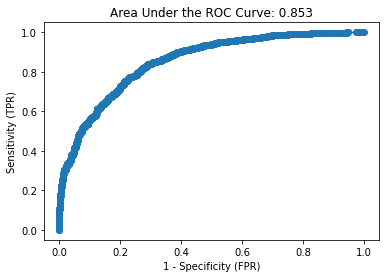

In [153]:
plot_roc(df_test_13['no_acc'], df_test_13['proba_bank'],fpr13_test,tpr13_test)

In [154]:
# calculate F1 score
f1_13_test = f1_score(df_test_13['no_acc'], preds13_test)
print('F1 score for bank account holiders in model 13:')
f1_13_test

F1 score for bank account holiders in model 13:


0.9340324118207817

In [155]:
df_test_13['preds'] = lm_13.predict(df_test_13[features13])

In [157]:
df_test_13.to_csv('test_preds.csv')

In [180]:
final_test = pd.concat([df_test_13,x_test_cat],axis=1)

In [182]:
#final_test.to_csv('test_preds.csv')

## Multiple regression with model 15 - Oversampling

In [193]:
preds15t = lm_15.predict(df_test_13[features13])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_15.score(
    df_test_13[features13], df_test_13['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.789


In [194]:
confusion_matrix(df_test_13['no_acc'], 
                 preds15t)

array([[ 619,  215],
       [1028, 4019]])

In [195]:
print(classification_report(df_test_13['no_acc'], preds15t))

              precision    recall  f1-score   support

           0       0.38      0.74      0.50       834
           1       0.95      0.80      0.87      5047

    accuracy                           0.79      5881
   macro avg       0.66      0.77      0.68      5881
weighted avg       0.87      0.79      0.81      5881



In [196]:
# calculate F1 score
f1_15t = f1_score(df_test_13['no_acc'], preds15t)
print('F1 score for test unbanked in model 15:')
f1_15t

F1 score for test unbanked in model 15:


0.8660704665445533